In [1]:
# Install MySql packages
# conda update -n base -c conda-forge conda --yes
# !pip install ipython-sql
# !pip install mysql-connector-python
# !conda install -c conda-forge python-dotenv --yes

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels as sm
import mysql.connector
from mysql.connector import Error
from os import environ, path
from dotenv import load_dotenv
from pandas.api.types import CategoricalDtype

In [3]:
# Read enviromental variables to connect the database
load_dotenv()
password = environ.get('PASSWORD')
host = environ.get('HOST')
database = environ.get('DATABASE')

In [4]:
# List of colors
colors = ['lime', 'darkorange', 'darkgreen', 'royalblue', 
         'darkred', 'gold', 'teal', 'blueviolet', 'coral', 
         'yellowgreen', 'steelblue', 'crimson', 'tan']

## Connect to the database and create dataframes for each table

In [5]:
try:
    connection = mysql.connector.connect(host=host ,
                                        database=database,
                                        user='root',
                                        password=password)
    if connection.is_connected():
        print("Succes Connected")
    df_musician = pd.read_sql_query("SELECT * FROM music_and_death.musician;", connection)
    df_birth = pd.read_sql_query("SELECT * FROM music_and_death.birth;", connection)
    df_death = pd.read_sql_query("SELECT * FROM music_and_death.death;", connection)
    df_genre = pd.read_sql_query("SELECT * FROM music_and_death.music_genre;", connection)
    genre = pd.read_sql_query("SELECT * FROM music_and_death.genre;", connection)
    cause_death = pd.read_sql_query("SELECT * FROM music_and_death.cause_death;", connection)
    cities = pd.read_sql_query("SELECT * FROM music_and_death.cities;", connection)
    states = pd.read_sql_query("SELECT * FROM music_and_death.states;", connection)
    countries = pd.read_sql_query("SELECT * FROM music_and_death.countries;", connection)
    
    
except Error as e:
    print("Error closing connection")

# Concatenate tables
else:
    # Concatenate musician and death dataframes
    df = pd.concat([df_musician, df_birth], axis=1)
    df = pd.concat([df, df_death], axis=1)
    df = pd.merge(df, cause_death, on=["death_id", "death_id"])
    df = df.loc[:, ~df.columns.duplicated()].copy()
    df = pd.merge(df, df_genre, on=["musician_id"])
    df = df.loc[:, ~df.columns.duplicated()].copy()
    df = pd.merge(df, genre, on=["genre_id"])
    # rearrange columns
    df = df.iloc[:, [0, 1, 2, 3, 5, 7, 8, 9, 11, 6, 4, 10]]
    
finally:
    connection.close()

Succes Connected


## Merge and clean the cities, states and countries tables

In [6]:
# merge cities table with states table
place = cities.merge(states, 
                      left_on=cities["state_id"], 
                      right_on=states["id"])

# drop duplicate keys
place.drop(['key_0', 'state_id', 'id_y'], axis=1, inplace=True)

# merge resulted table with countries table
place = place.merge(countries, 
                        left_on=place["country_id"],
                        right_on=countries["id"])

# drop duplicated keys
place.drop(['key_0', 'country_id', 'id', 'iso2', 'capital'], 
              axis=1, 
              inplace=True)

# rename column names
place.rename(
    columns={'name_x': 'City', 
             'name_y': 'State', 
             'name': 'Country', 
             'id_x': 'city_id'},
    inplace=True
)

##  Drop columns with not use

In [7]:
df.drop(['middle_name', 'death_id', "death_date", "genre_id", "birth"], 
        axis=1, 
        inplace=True)

In [8]:
df

,musician_id,stage_name,stage_lastname,death_age,cause,genre,birthplace_id
0,1,John,Lennon,40,homicide,rock,50337
1,432,Kit,Lambert,45,homicide,rock,50388
2,459,Rusty,Day,36,homicide,rock,117057
3,481,Felix,Pappalardi,43,homicide,rock,122795
4,559,Tommy,Blake,54,homicide,rock,114990
...,...,...,...,...,...,...,...
766,516,Meredith,Willson,82,heart disease,classical,121375
767,478,William,Walton,80,natural causes,classical,50807
768,703,Irving,Berlin,101,natural causes,classical,102005
769,185,Nelson,Eddy,65,brain related,classical,124716


In [9]:
place

,city_id,City,State,Country
0,52,Ashkāsham,Badakhshan,Afghanistan
1,68,Fayzabad,Badakhshan,Afghanistan
2,78,Jurm,Badakhshan,Afghanistan
3,84,Khandūd,Badakhshan,Afghanistan
4,115,Rāghistān,Badakhshan,Afghanistan
...,...,...,...,...
148261,131496,Redcliff,Midlands Province,Zimbabwe
148262,131502,Shangani,Midlands Province,Zimbabwe
148263,131503,Shurugwi,Midlands Province,Zimbabwe
148264,131504,Shurugwi District,Midlands Province,Zimbabwe


## Merge musician info dataframe with place dataframe

In [10]:
# merge df and place dataframes
musician = df.merge(place, 
                    left_on=df['birthplace_id'], 
                    right_on=place['city_id'])

# drop unused columns
musician.drop(['birthplace_id', 'city_id', 'key_0'], axis=1, inplace=True)

In [11]:
musician

,musician_id,stage_name,stage_lastname,death_age,cause,genre,City,State,Country
0,1,John,Lennon,40,homicide,rock,Liverpool,England,United Kingdom
1,271,Rory,Storm,34,suicide,rock,Liverpool,England,United Kingdom
2,502,Tom,Evans,36,suicide,rock,Liverpool,England,United Kingdom
3,473,Billy,Fury,42,heart disease,rock,Liverpool,England,United Kingdom
4,188,Brian,Epstein,32,drugs related,rock,Liverpool,England,United Kingdom
...,...,...,...,...,...,...,...,...,...
765,516,Meredith,Willson,82,heart disease,classical,Mason City,Iowa,United States
766,478,William,Walton,80,natural causes,classical,Oldham,England,United Kingdom
767,703,Irving,Berlin,101,natural causes,classical,Tyumen,Tyumen Oblast,Russia
768,185,Nelson,Eddy,65,brain related,classical,Providence,Rhode Island,United States


In [12]:
musician.to_csv('musicians.csv')

## Create plots to observe the data

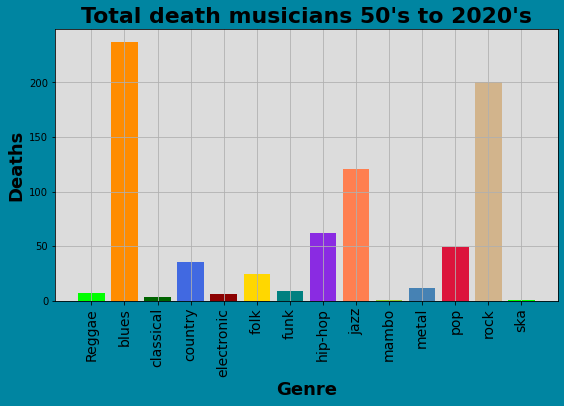

In [13]:
# Bar plot to show deaths per music genre 

# Create a new music table using genre as indez and size of each genre
df_n = musician.pivot_table(index=['genre'], aggfunc='size')

# plot the data
plt.figure(figsize=(9,5), facecolor='#0085a1')
ax = plt.axes()
ax.set_facecolor("gainsboro")
ax.set_title("Total death musicians 50's to 2020's",
             size=22,
             fontweight="bold" )
plt.bar(df_n.index, df_n, color=colors)
plt.ylabel("Deaths", size=18, fontweight="bold")
plt.xlabel("Genre", size=18, fontweight="bold")
plt.xticks(rotation='vertical', size=14)
plt.grid()
plt.show()

## Cause of death per music genre

In [14]:
df_cd = musician.pivot_table(index=['cause', 'genre'], aggfunc='size')
df_cd

cause    genre     
AIDS     blues          1
         electronic     1
         funk           1
         pop            3
         rock           6
                       ..
unknown  folk           3
         funk           1
         jazz          16
         pop            4
         rock           5
Length: 116, dtype: int64

# Questions

## Most common Death Ages


In [15]:
n_da = musician['death_age'].value_counts().nlargest(10)

In [16]:
n_da

27    32
32    28
28    21
37    21
36    19
42    17
39    17
24    17
34    16
47    16
Name: death_age, dtype: int64

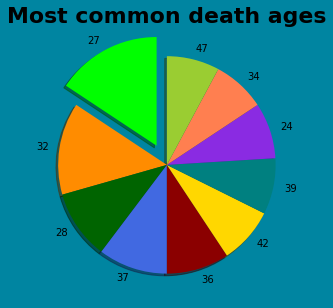

In [17]:
plt.figure(figsize=(9,5), facecolor='#0085a1')
ax = plt.axes()
ax.set_title("Most common death ages",
             size=22,
             fontweight="bold" )
plt.pie(n_da.values, labels=n_da.index, 
        colors=colors,
        startangle=90,
        shadow=True,
        explode = [0.2, 0, 0, 0, 0, 0, 0, 0, 0, 0])
plt.show()

## Most common Music Genre deaths

In [18]:
n_mg = musician['genre'].value_counts()

In [19]:
n_mg

blues         237
rock          200
jazz          121
hip-hop        62
pop            49
country        36
folk           25
metal          12
funk            9
Reggae          7
electronic      6
classical       4
ska             1
mambo           1
Name: genre, dtype: int64

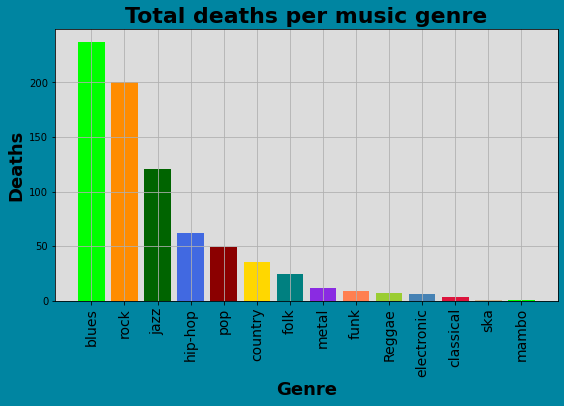

In [20]:
plt.figure(figsize=(9,5), facecolor='#0085a1')
ax = plt.axes()
ax.set_facecolor('gainsboro')
ax.set_title("Total deaths per music genre",
             size=22,
             fontweight="bold" )
plt.bar(n_mg.index, n_mg.values, color=colors)
plt.ylabel("Deaths", size=18, fontweight="bold")
plt.xlabel("Genre", size=18, fontweight="bold")
plt.xticks(rotation='vertical', size=14)
plt.grid()
plt.show()

# Places

### Most common countries of origin of dead musicians

In [21]:
n_places = musician['Country'].value_counts().nlargest(10)

In [22]:
n_places

United States     614
United Kingdom     77
Canada             10
Jamaica             9
Germany             8
Australia           6
Russia              4
Poland              3
South Africa        3
France              3
Name: Country, dtype: int64

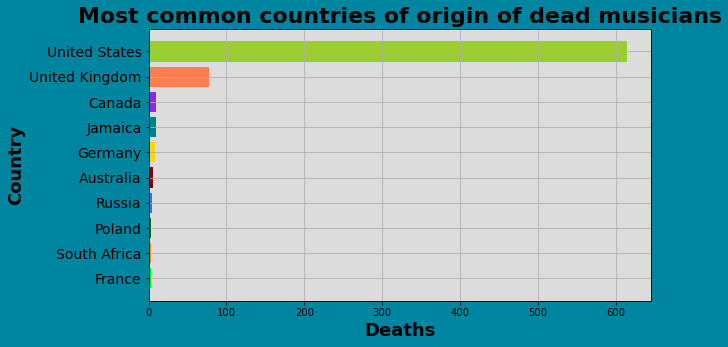

In [23]:
plt.figure(figsize=(9,5), facecolor='#0085a1')
ax = plt.axes()
ax.set_facecolor('gainsboro')
ax.set_title("Most common countries of origin of dead musicians",
            size=22,
            fontweight="bold")
plt.barh(n_places.iloc[::-1].index, n_places.iloc[::-1].values, color=colors)
plt.ylabel("Country", size=18, fontweight="bold")
plt.xlabel("Deaths", size=18, fontweight="bold")
plt.yticks(size=14)
plt.grid()
plt.show()

### Most common States of origin of dead musicians

In [24]:
n_states = musician['State'].value_counts().nlargest(10)

In [25]:
n_states

New York        67
England         64
Mississippi     62
California      48
Texas           47
Louisiana       38
Tennessee       35
Illinois        28
Pennsylvania    27
Georgia         22
Name: State, dtype: int64

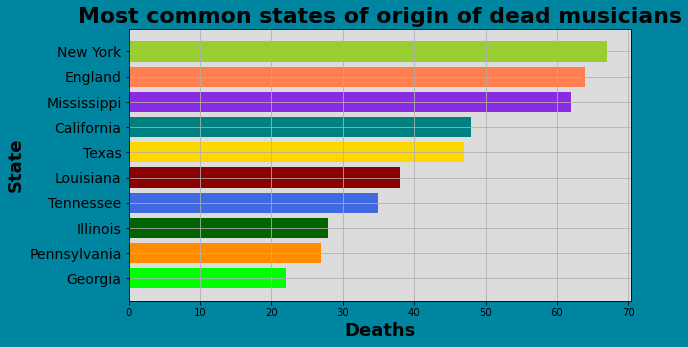

In [26]:
plt.figure(figsize=(9,5), facecolor='#0085a1')
ax = plt.axes()
ax.set_facecolor('gainsboro')
ax.set_title("Most common states of origin of dead musicians",
            size=22,
            fontweight="bold")
plt.barh(n_states.iloc[::-1].index, n_states.iloc[::-1].values, color=colors)
plt.ylabel("State", size=18, fontweight="bold")
plt.xlabel("Deaths", size=18, fontweight="bold")
plt.yticks(size=14)
plt.grid()
plt.show()

### Most common Cities

In [27]:
n_cities = musician['City'].value_counts().nlargest(10)

In [28]:
n_cities

New York City    36
London           28
Chicago          25
Los Angeles      19
Philadelphia     17
Memphis          16
New Orleans      16
Birmingham       13
Detroit           8
Dallas            8
Name: City, dtype: int64

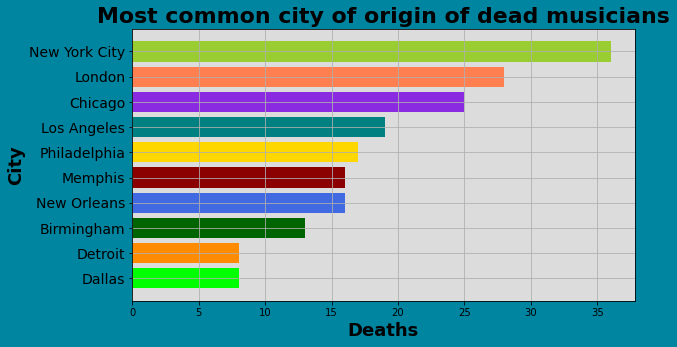

In [29]:
plt.figure(figsize=(9, 5), facecolor='#0085a1')
ax = plt.axes()
ax.set_facecolor('gainsboro')
ax.set_title("Most common city of origin of dead musicians",
            size=22,
            fontweight="bold")
plt.barh(n_cities.iloc[::-1].index, n_cities.iloc[::-1].values, color=colors)
plt.ylabel("City", size=18, fontweight="bold")
plt.xlabel("Deaths", size=18, fontweight="bold")
plt.yticks(size=14)
plt.grid()
plt.show()

## Death genre - cause

In [30]:
n_cd_gr = musician.loc[:, ['genre', 'cause']].value_counts()

In [31]:
n_cd_gr.head(10)

genre    cause                  
blues    heart disease              66
hip-hop  homicide                   58
blues    unknown                    45
         cancer                     36
jazz     heart disease              34
rock     drugs related              32
         heart disease              31
jazz     cancer                     29
rock     suicide                    24
         car/motorcycle accident    22
dtype: int64

In [32]:
n_cd_gr = n_cd_gr.reset_index()
n_cd_gr.rename(columns={0: 'deaths'}, inplace=True)

In [33]:
n_cd_gr

,genre,cause,deaths
0,blues,heart disease,66
1,hip-hop,homicide,58
2,blues,unknown,45
3,blues,cancer,36
4,jazz,heart disease,34
...,...,...,...
111,pop,accidental self-inflicted gunshot,1
112,folk,homicide,1
113,pop,drawning,1
114,jazz,aircraft accident,1


### Blues 

In [34]:
n_blues = n_cd_gr.loc[n_cd_gr['genre'] == 'blues', ]

In [35]:
n_blues

,genre,cause,deaths
0,blues,heart disease,66
2,blues,unknown,45
3,blues,cancer,36
14,blues,homicide,14
16,blues,respiratory disease,13
21,blues,diabetes,9
22,blues,drugs related,8
23,blues,car/motorcycle accident,8
25,blues,brain related,7
27,blues,alcohol related,6


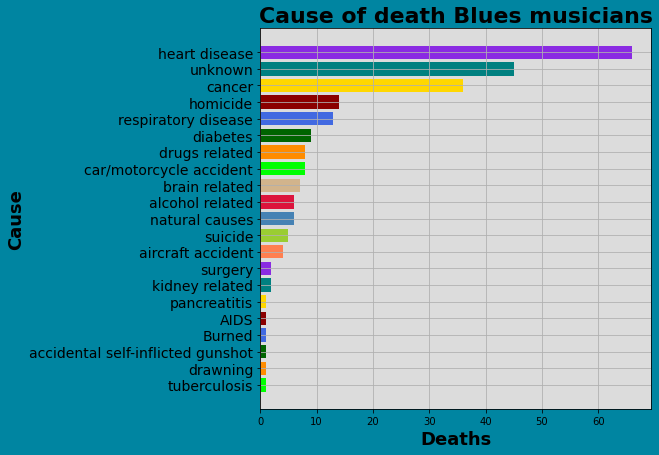

In [36]:
plt.figure(figsize=(7,7), facecolor='#0085a1')
ax = plt.axes()
ax.set_facecolor('gainsboro')
ax.set_title("Cause of death Blues musicians",
            size=22,
            fontweight="bold")
plt.barh(n_blues['cause'].iloc[::-1],
         n_blues['deaths'].iloc[::-1],
         color=colors)
plt.ylabel("Cause", size=18, fontweight="bold")
plt.xlabel("Deaths", size=18, fontweight="bold")
plt.yticks(size=14)
plt.grid()
plt.show()


### Rock

In [37]:
n_rock = n_cd_gr.loc[n_cd_gr['genre'] == 'rock', ]

In [38]:
n_rock

,genre,cause,deaths
5,rock,drugs related,32
6,rock,heart disease,31
8,rock,suicide,24
9,rock,car/motorcycle accident,22
10,rock,cancer,19
13,rock,alcohol related,14
18,rock,brain related,10
19,rock,aircraft accident,9
20,rock,respiratory disease,9
24,rock,drawning,7


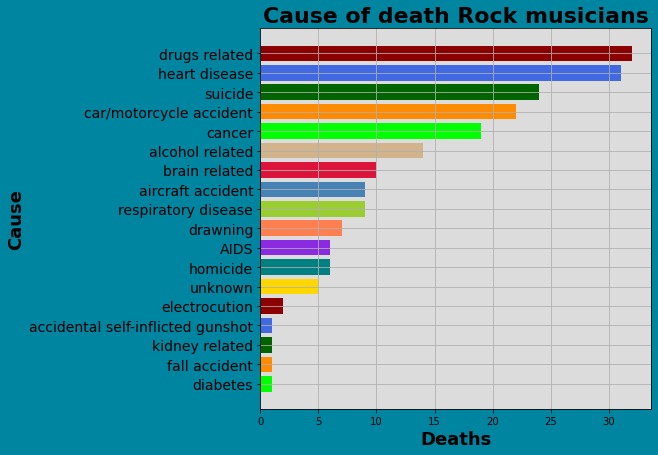

In [39]:
plt.figure(figsize=(7,7), facecolor='#0085a1')
ax = plt.axes()
ax.set_facecolor('gainsboro')
ax.set_title("Cause of death Rock musicians",
            size=22,
            fontweight="bold")
plt.barh(n_rock['cause'].iloc[::-1],
         n_rock['deaths'].iloc[::-1],
         color=colors)

plt.ylabel("Cause", size=18, fontweight="bold")
plt.xlabel("Deaths", size=18, fontweight="bold")
plt.yticks(size=14)
plt.grid()
plt.show()


### Jazz

In [40]:
n_jazz = n_cd_gr.loc[n_cd_gr['genre'] == 'jazz', ]

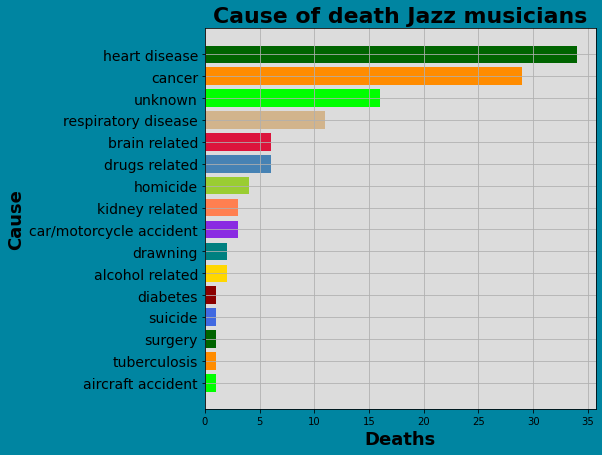

In [41]:
plt.figure(figsize=(7,7), facecolor='#0085a1')
ax = plt.axes()
ax.set_facecolor('gainsboro')
ax.set_title("Cause of death Jazz musicians",
            size=22,
            fontweight="bold")
plt.barh(n_jazz['cause'].iloc[::-1],
         n_jazz['deaths'].iloc[::-1],
         color=colors)

plt.ylabel("Cause", size=18, fontweight="bold")
plt.xlabel("Deaths", size=18, fontweight="bold")
plt.yticks(size=14)
plt.grid()
plt.show()

## Most common Cause o deaths

In [42]:
n_cause_death = musician['cause'].value_counts().nlargest(10)

In [43]:
n_cause_death

heart disease              163
cancer                     104
homicide                    91
unknown                     80
drugs related               63
car/motorcycle accident     47
respiratory disease         42
suicide                     38
aircraft accident           28
brain related               25
Name: cause, dtype: int64

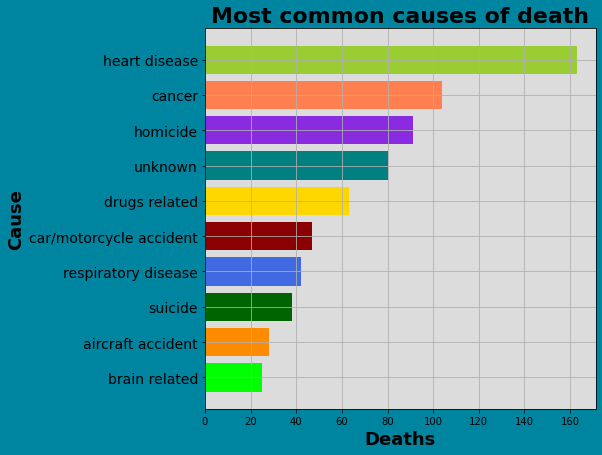

In [44]:
plt.figure(figsize=(7,7), facecolor='#0085a1')
ax = plt.axes()
ax.set_facecolor('gainsboro')
ax.set_title("Most common causes of death",
            size=22,
            fontweight="bold")
plt.barh(n_cause_death.iloc[::-1].index,
         n_cause_death.iloc[::-1].values,
         color=colors)

plt.ylabel("Cause", size=18, fontweight="bold")
plt.xlabel("Deaths", size=18, fontweight="bold")
plt.yticks(size=14)
plt.grid()
plt.show()
